In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")

import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set random seed for reproducibility
tf.random.set_seed(42)

In [98]:
df = pd.read_csv("Bitcoin_price.csv")

In [33]:
df.tail()

,Date,Open,High,Low,Close,Volume,MarketCap
2811,08-Jan-21,39381.77,41946.74,36838.64,40797.61,8.810752e+10,7.590000e+11
2812,09-Jan-21,40788.64,41436.35,38980.88,40254.55,6.198416e+10,7.490000e+11
2813,10-Jan-21,40254.22,41420.19,35984.63,38356.44,7.998075e+10,7.130000e+11
2814,11-Jan-21,38346.53,38346.53,30549.60,35566.66,1.233210e+11,6.614570e+11
2815,12-Jan-21,35516.36,36568.53,32697.98,33922.96,7.477328e+10,6.309200e+11


In [100]:
# Check out variables
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
MarketCap    float64
dtype: object

In [101]:
# We see Date is an object, so we have to convert it to datetime
df['Date'] = df['Date'].astype('datetime64[ns]')

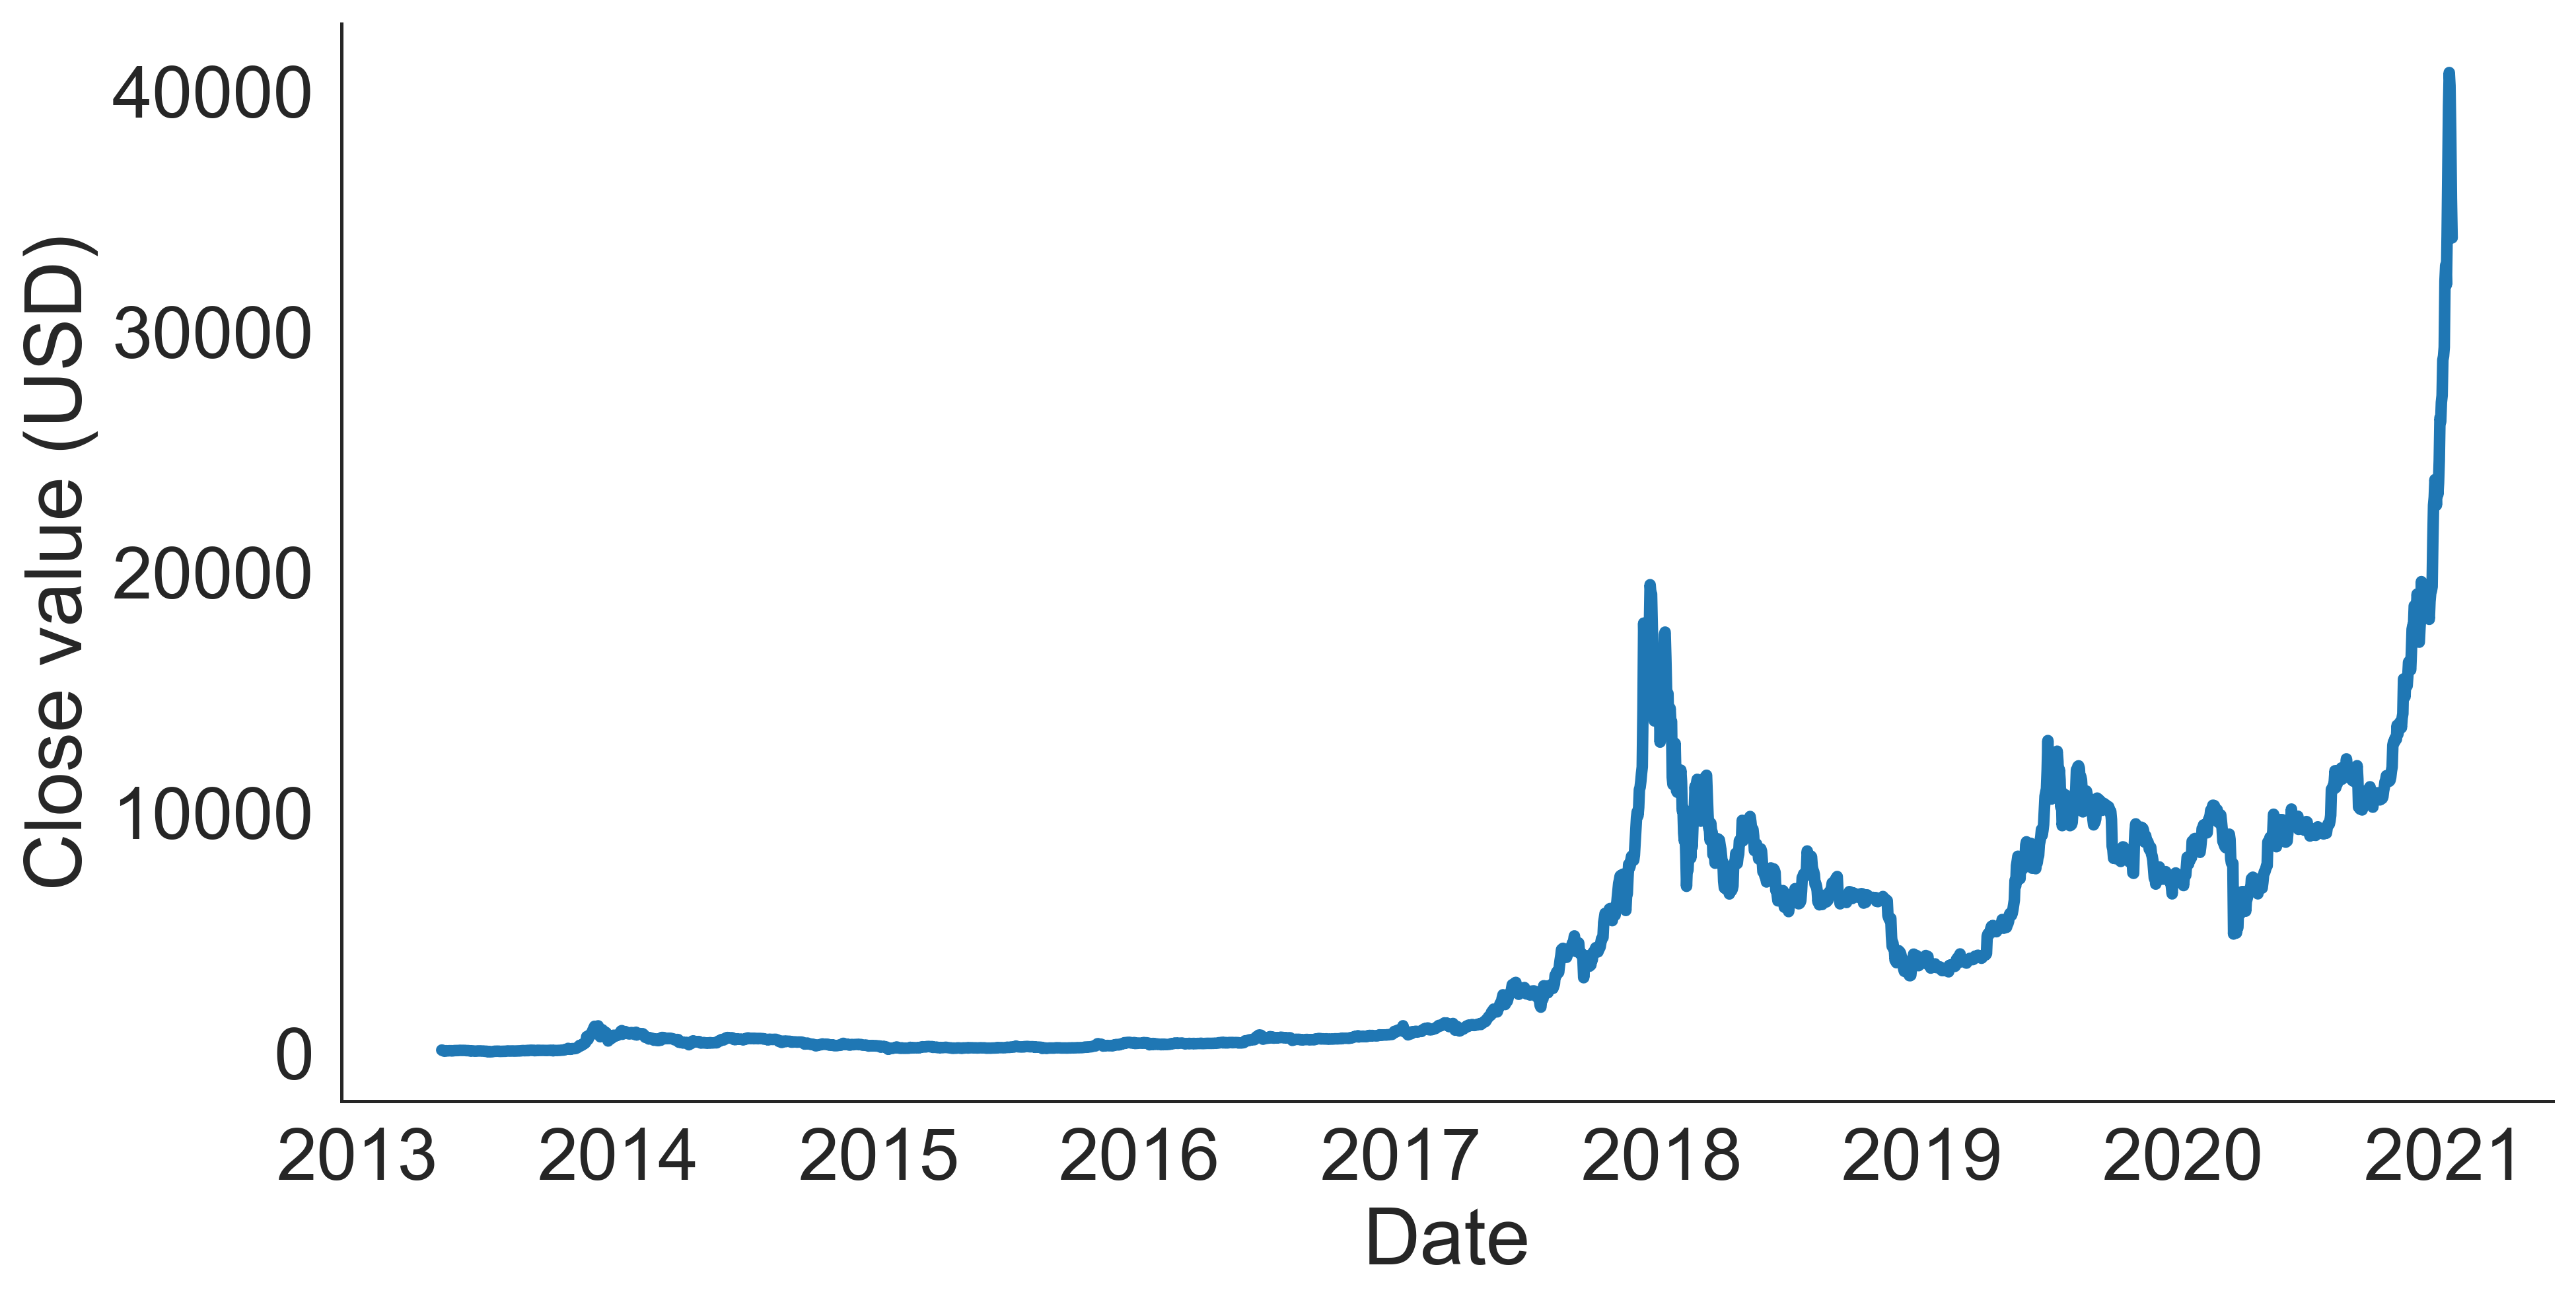

In [102]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3.5})
plt.rcParams['figure.dpi'] = 360
sns.lineplot(data=df, x="Date", y="Close")
plt.xlabel("Date") 
plt.ylabel("Close value (USD)") 
#plt.title("Evolution of Bitcoin price")
horizontalalignment='center'
sns.despine()

In [103]:
# Create variable 'TOMORROW_CLOSE' which shifts 'Close' up by 1
df['TOMORROW_CLOSE'] = df['Close'].shift(-1,fill_value=0)

In [104]:
# drop last row because we shifted value (remember this when you add your forecasting data)
df.drop(df.tail(1).index,inplace=True) 

In [105]:
df = df.drop(columns=['Close'])

In [106]:
df = df.set_index('Date')

In [107]:
df.tail()

,Open,High,Low,Volume,MarketCap,TOMORROW_CLOSE
Date,,,,,,
2021-01-07,36833.87,40180.37,36491.19,8.476214e+10,7.320000e+11,40797.61
2021-01-08,39381.77,41946.74,36838.64,8.810752e+10,7.590000e+11,40254.55
2021-01-09,40788.64,41436.35,38980.88,6.198416e+10,7.490000e+11,38356.44
2021-01-10,40254.22,41420.19,35984.63,7.998075e+10,7.130000e+11,35566.66
2021-01-11,38346.53,38346.53,30549.60,1.233210e+11,6.614570e+11,33922.96


In [108]:
# Split train data (80%) and test data (20%)
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

Dimension of train data:  (2252, 6)
Dimension of test data:  (563, 6)


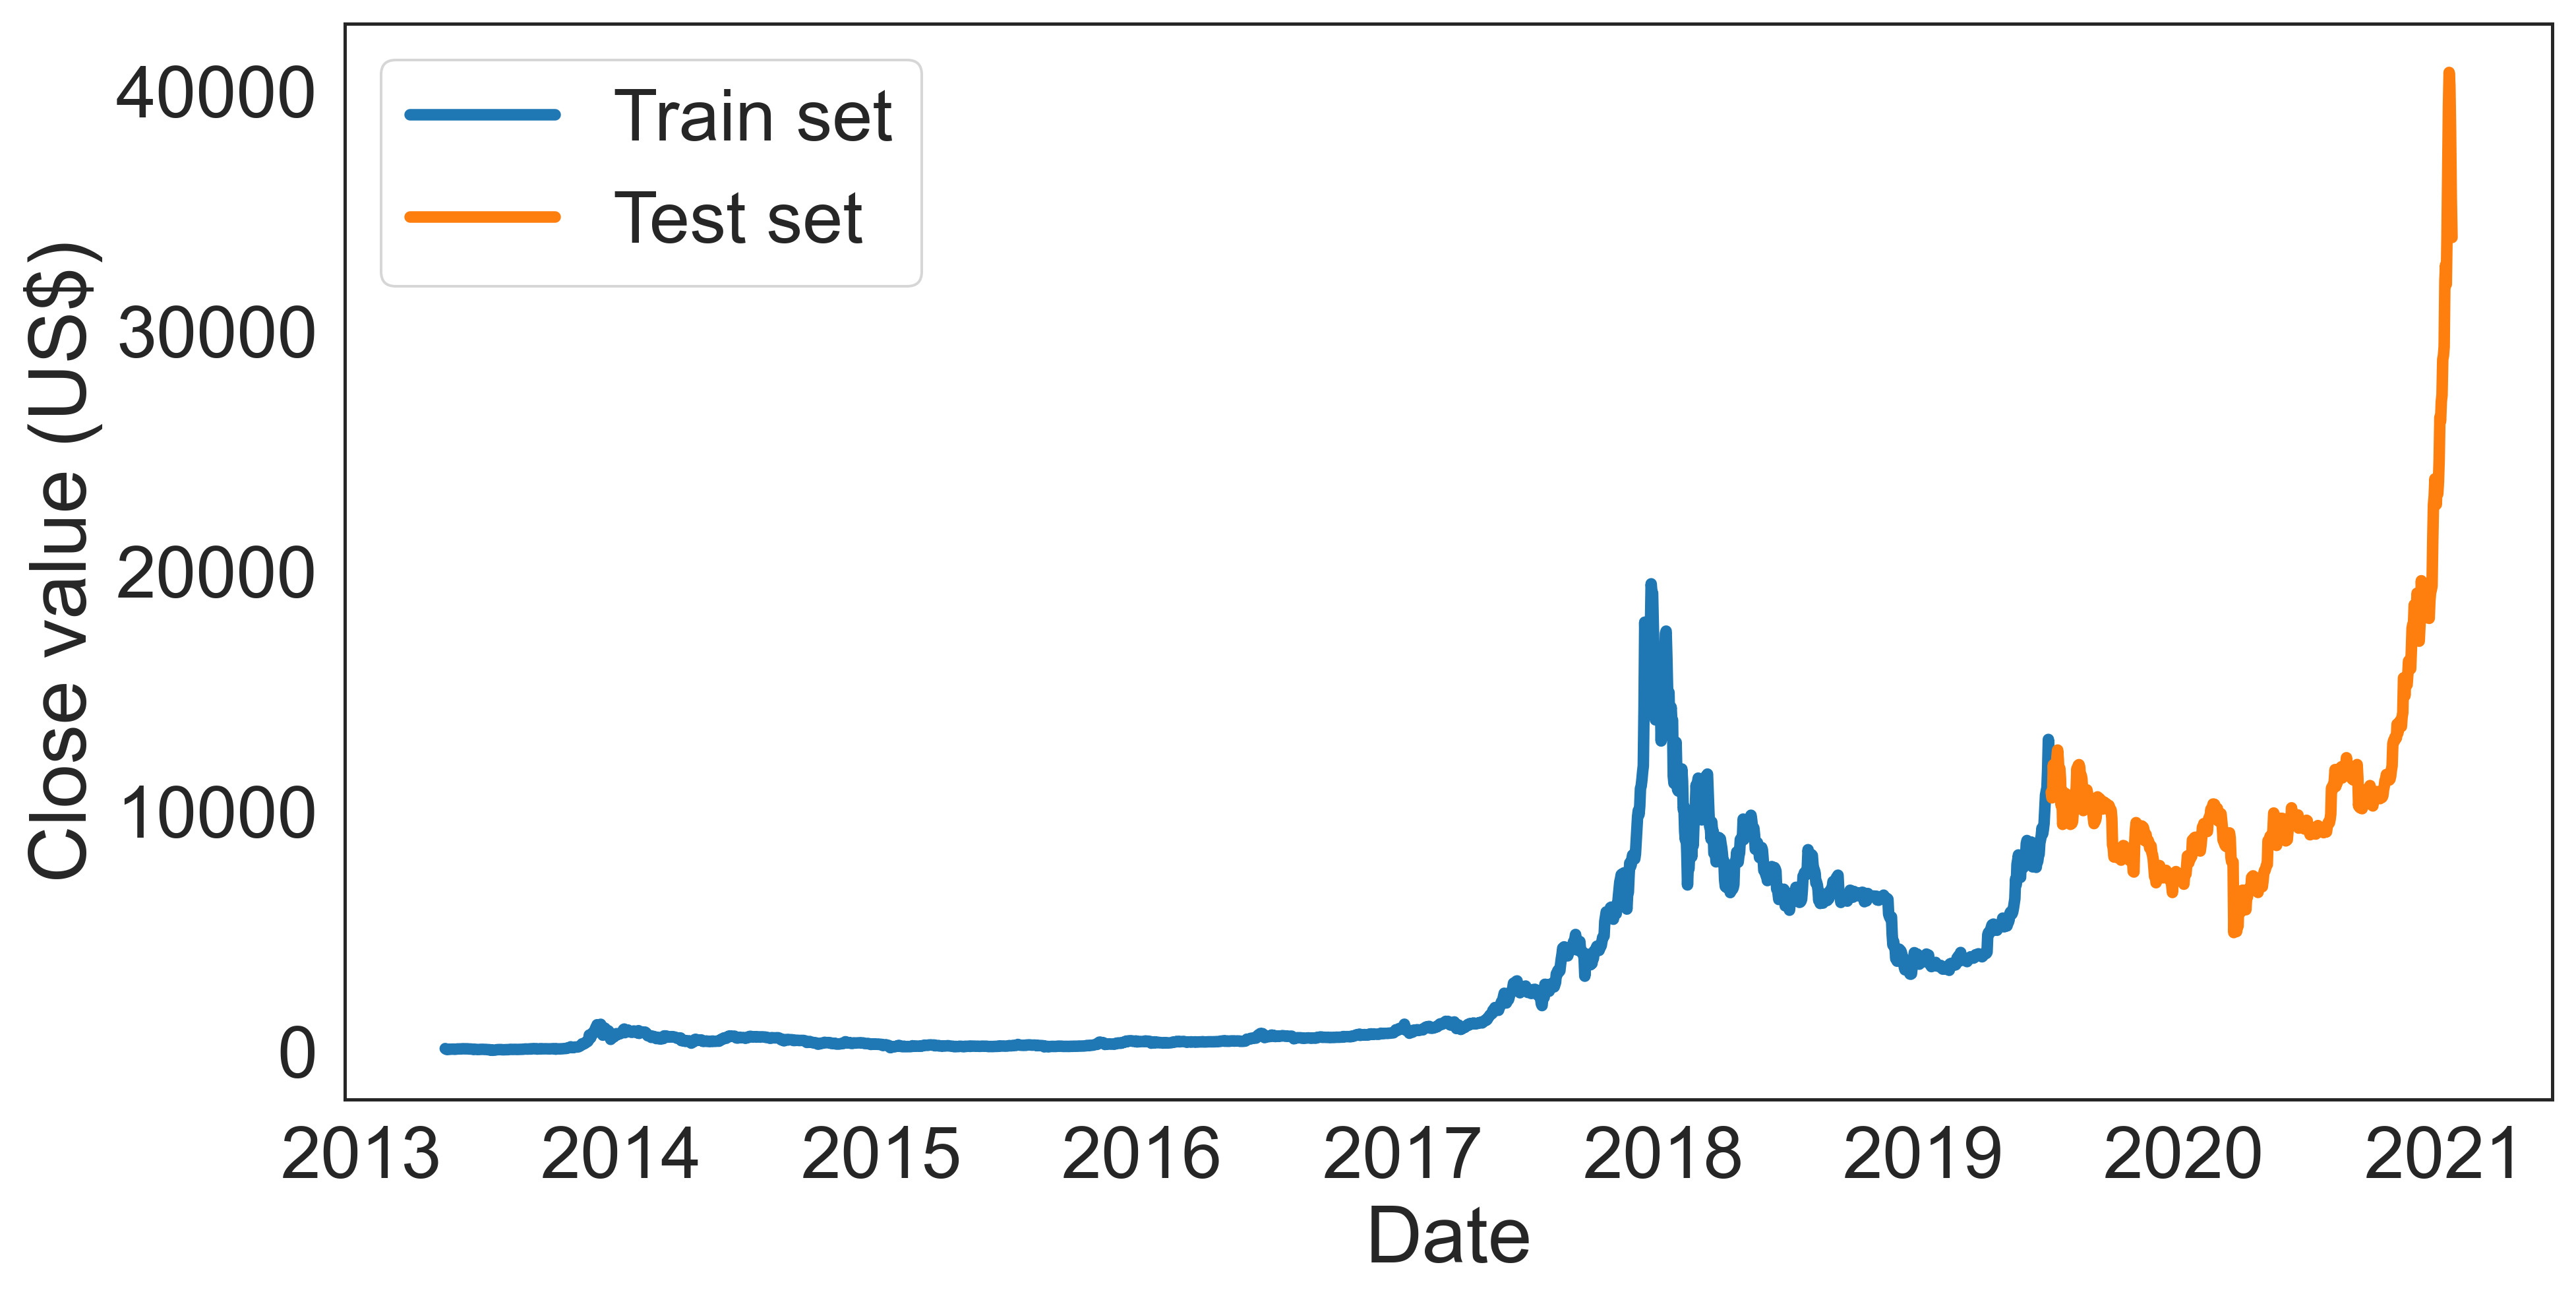

In [110]:
# Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [41]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]
# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [42]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [43]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (553, 10, 5)
y_train.shape:  (2242, 1)
X_test.shape:  (553, 10, 5)
y_test.shape:  (2242, 1)


In [44]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [45]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0456 - val_loss: 0.0058
Epoch 2/100
57/57 [==============================] - 2s 41ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 3/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 4/100
57/57 [==============================] - 3s 50ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 5/100
57/57 [==============================] - 2s 43ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 6/100
57/57 [==============================] - 2s 41ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 7/100
57/57 [==============================] - 3s 44ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 8/100
57/57 [==============================] - 2s 41ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 9/100
57/57 [==============================] - 3s 45ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 10/100
57/57 [==============================] - 2s 41ms/step - loss: 0.0069 - val_loss: 0.006

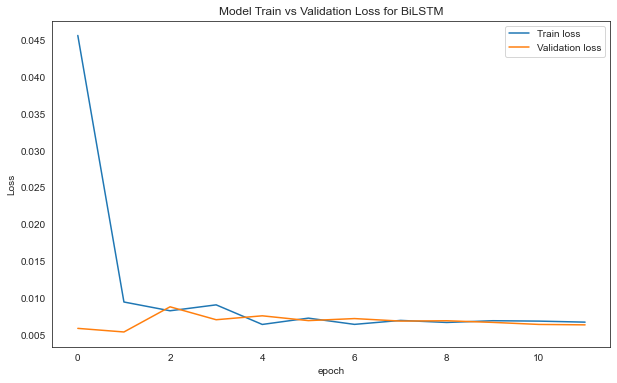

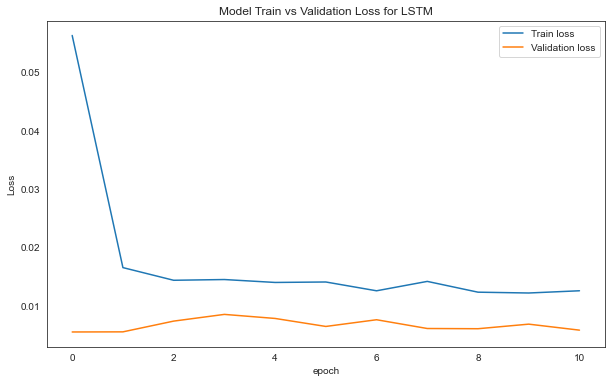

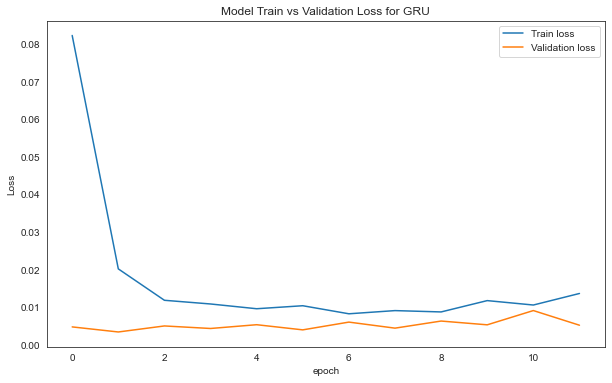

In [46]:
#Plot train and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [47]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [48]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

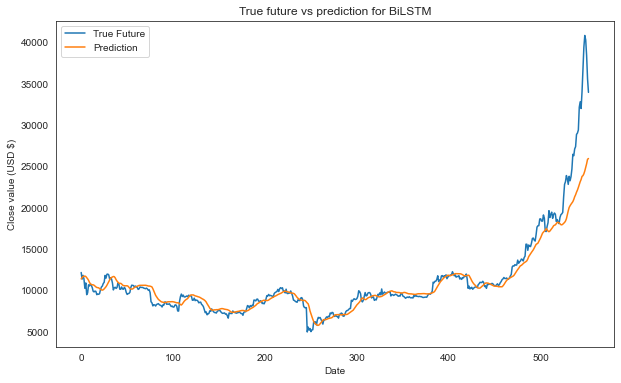

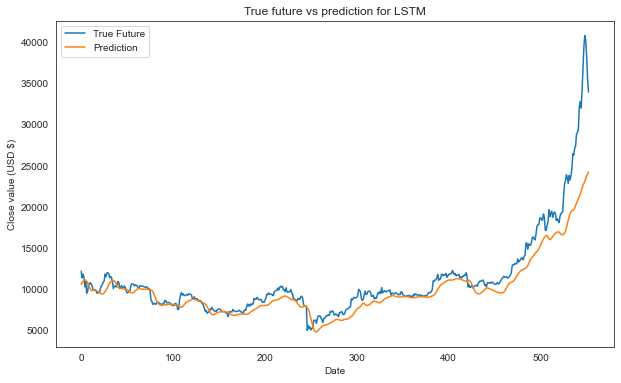

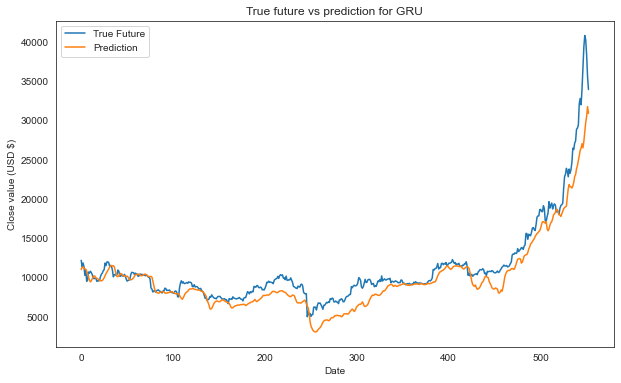

In [49]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [50]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 913.1505
Root Mean Square Error: 2052.0953

LSTM:
Mean Absolute Error: 1286.4657
Root Mean Square Error: 2459.7244

GRU:
Mean Absolute Error: 1334.7935
Root Mean Square Error: 1934.8952



In [74]:
# Import forecast data
forecast_df = pd.read_csv('Bitcoin_forecast_3.csv')

In [75]:
forecast_df.head(10)

,Date,Open,High,Low,Volume,MarketCap
0,12-Jan-21,35516.36,36568.53,32697.98,74773277909,6.309200e+11
1,13-Jan-21,33915.12,37599.96,32584.67,69364315979,6.940700e+11
2,14-Jan-21,37325.11,39966.41,36868.56,63615990033,7.289040e+11
3,15-Jan-21,39156.71,39577.71,34659.59,67760757881,6.850060e+11
4,16-Jan-21,36821.65,37864.37,35633.55,57706187875,6.730010e+11
5,17-Jan-21,36163.65,36722.35,34069.32,52359854336,6.658320e+11
6,18-Jan-21,35792.24,37299.29,34883.84,49511702429,6.810000e+11
7,19-Jan-21,36642.23,37755.89,36069.81,57244195486,6.710000e+11
8,20-Jan-21,36050.11,36378.33,33570.48,66834573161,6.610000e+11
9,21-Jan-21,35549.40,35552.68,30250.75,75643067688,5.740000e+11


In [76]:
# We see Date is an object, so we have to convert it to datetime
forecast_df['Date'] = forecast_df['Date'].astype('datetime64[ns]')

In [77]:
forecast_df = forecast_df.set_index('Date')

In [78]:
forecast_df.shape

(12, 5)

In [27]:
forecast_df.dtypes

Open         float64
High         float64
Low          float64
Volume         int64
MarketCap    float64
dtype: object

In [79]:
forecast_df.Volume = forecast_df.Volume.astype(float)

In [115]:
X_new = forecast_df.loc['2021-01-12': '2021-01-23',:]
X_new

,Open,High,Low,Volume,MarketCap
Date,,,,,
2021-01-12,35516.36,36568.53,32697.98,7.477328e+10,6.309200e+11
2021-01-13,33915.12,37599.96,32584.67,6.936432e+10,6.940700e+11
2021-01-14,37325.11,39966.41,36868.56,6.361599e+10,7.289040e+11
2021-01-15,39156.71,39577.71,34659.59,6.776076e+10,6.850060e+11
2021-01-16,36821.65,37864.37,35633.55,5.770619e+10,6.730010e+11
2021-01-17,36163.65,36722.35,34069.32,5.235985e+10,6.658320e+11
2021-01-18,35792.24,37299.29,34883.84,4.951170e+10,6.810000e+11
2021-01-19,36642.23,37755.89,36069.81,5.724420e+10,6.710000e+11
2021-01-20,36050.11,36378.33,33570.48,6.683457e+10,6.610000e+11


In [122]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (US $)')
    

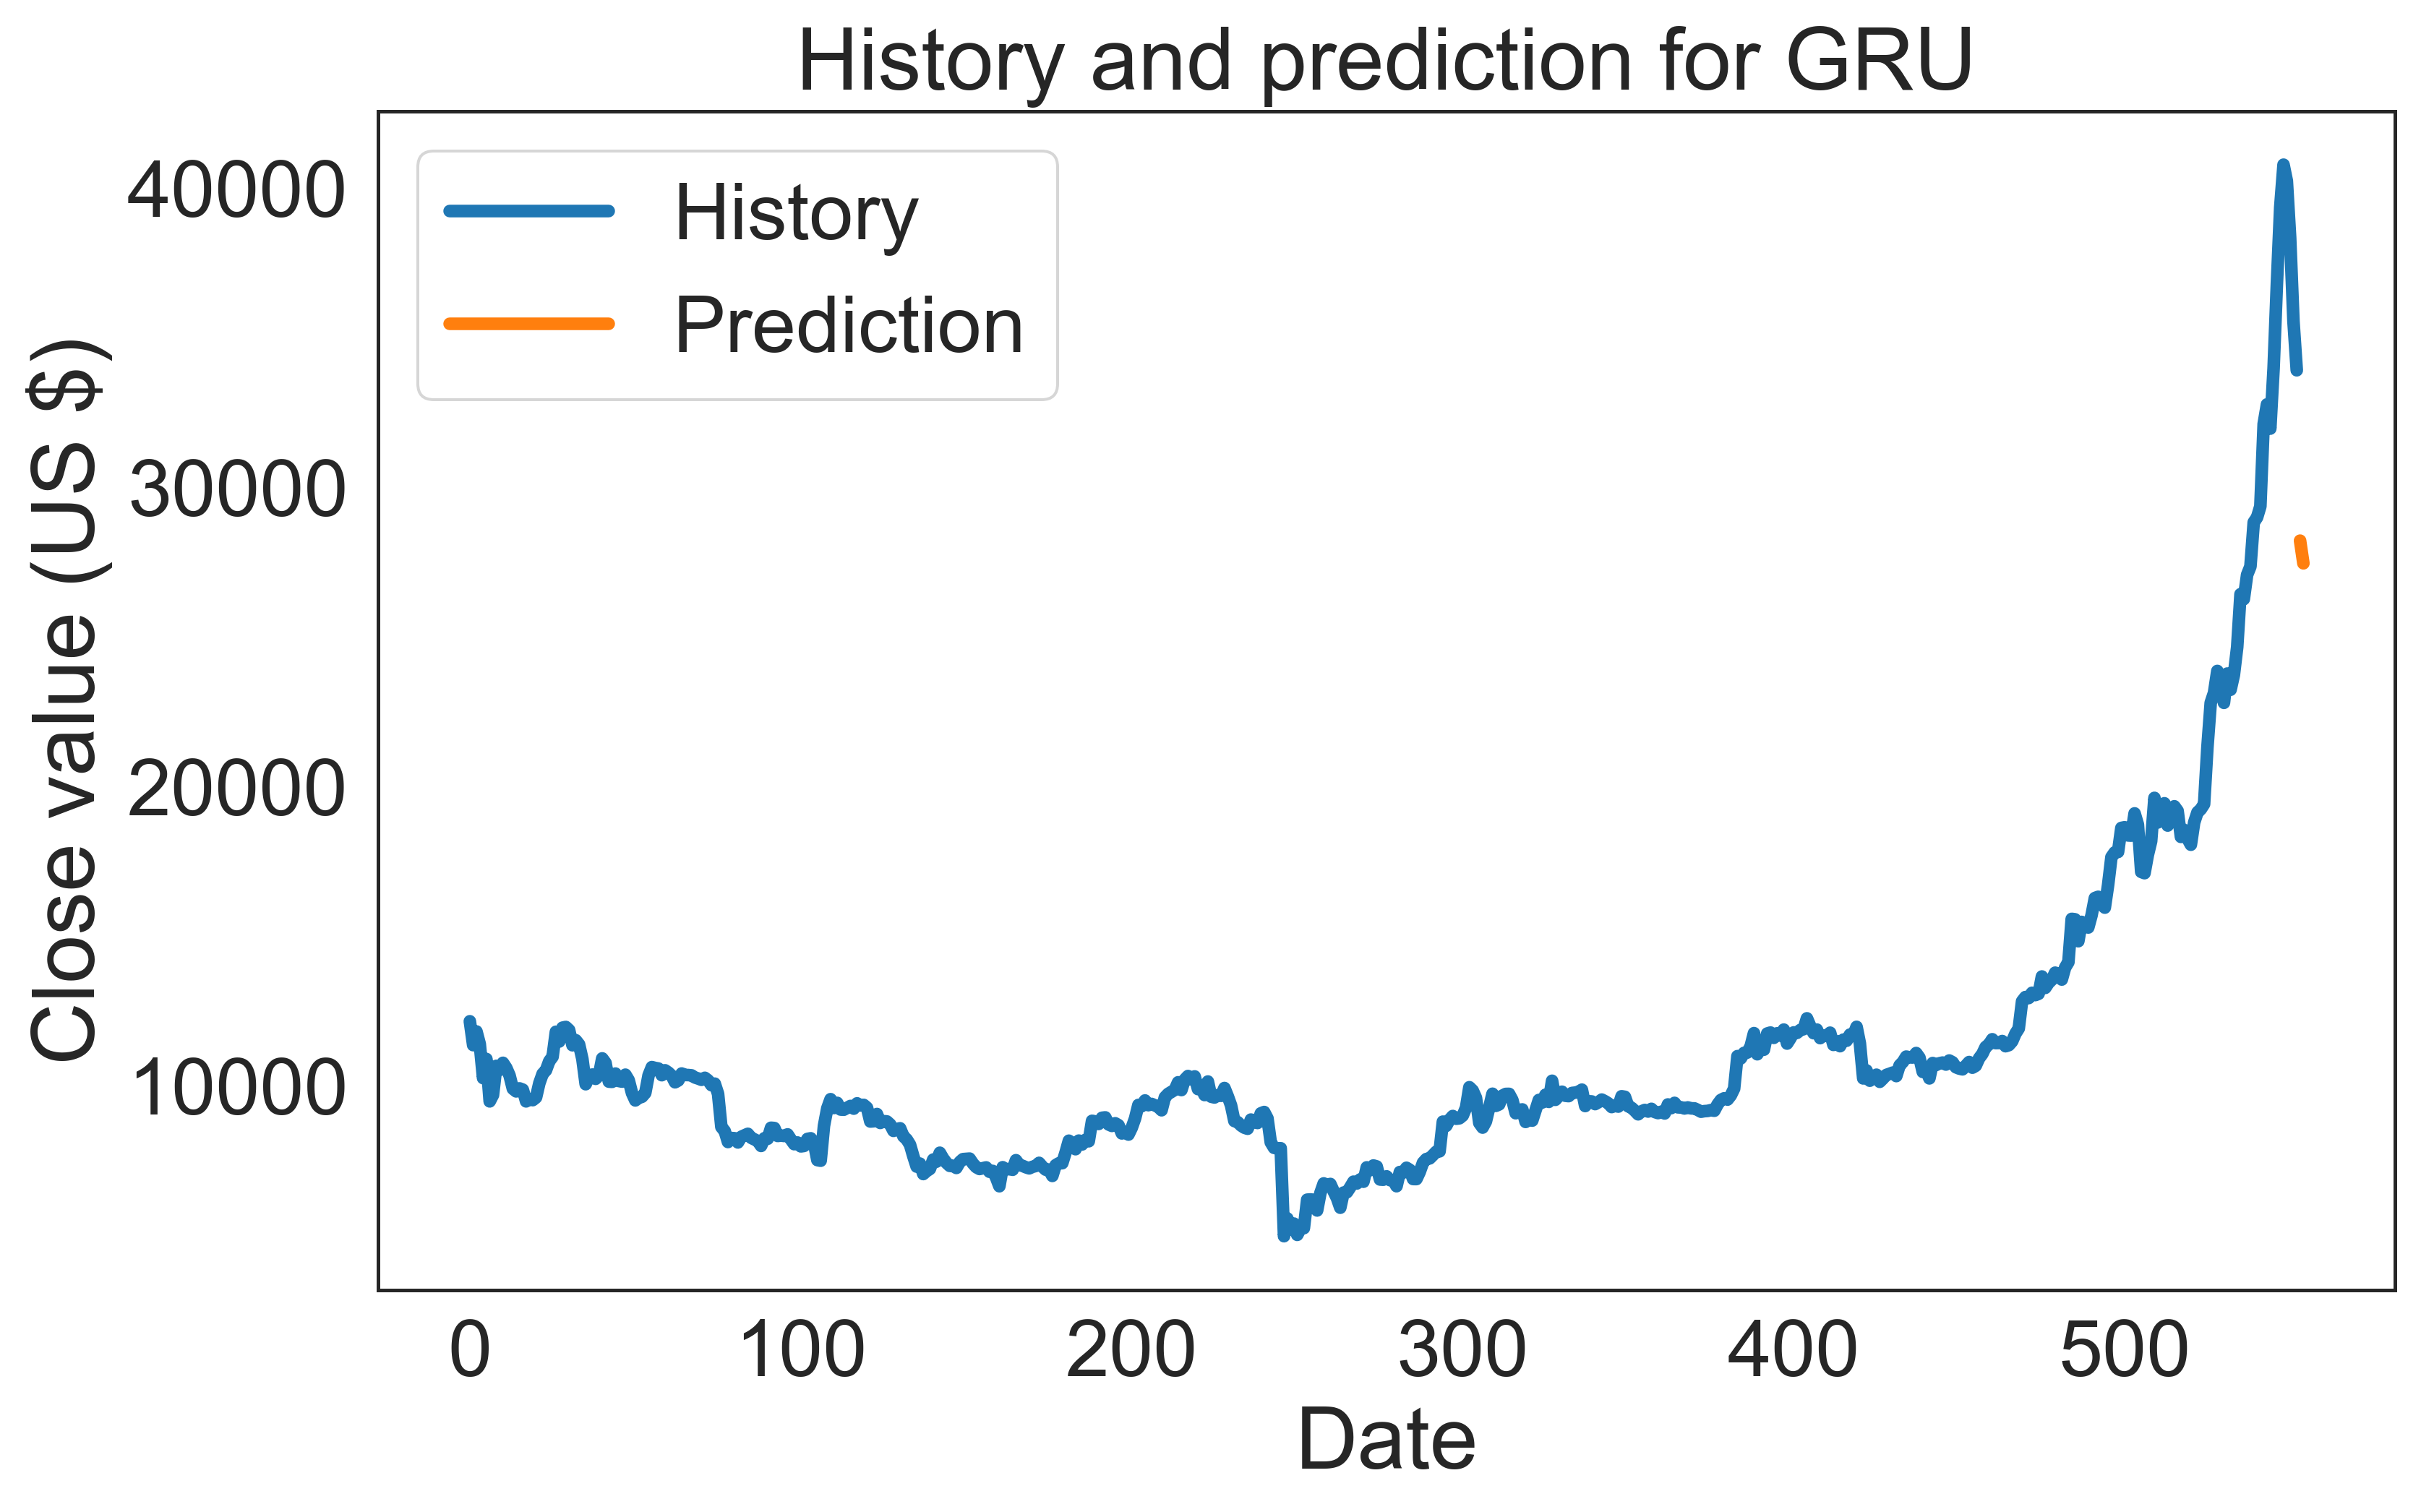

In [123]:
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using GRU model 
    prediction = model_gru.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual



prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_test, prediction,'GRU')

In [124]:
prediction

array([[28226.107],
       [27468.18 ]], dtype=float32)